In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from dataset import ImageDataset
import config
from torch import optim
from unet import UNET
from torch import nn
from dice_score import dice_loss
import torch.nn.functional as F
import utils

import matplotlib.pyplot as plt


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
  data = fetch_version_info()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2BD1B165-EC09-3F68-BCE4-8FE4E70CA7E2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using im

In [2]:
# Creating Dataloader
train_set = ImageDataset(config.TRAIN_DIR, transforms=config.train_transform)
train_dl = DataLoader(train_set, shuffle=True, batch_size=config.TRAIN_BATCH_SIZE)

val_set = ImageDataset(config.VAL_DIR, transforms=config.val_transforms)
val_dl = DataLoader(val_set, shuffle=False, batch_size=config.VAL_BATCH_SIZE)


In [3]:
model = UNET(in_channels=3, out_channels=3).to(config.DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [ ]:
if config.LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

<Figure size 500x500 with 0 Axes>

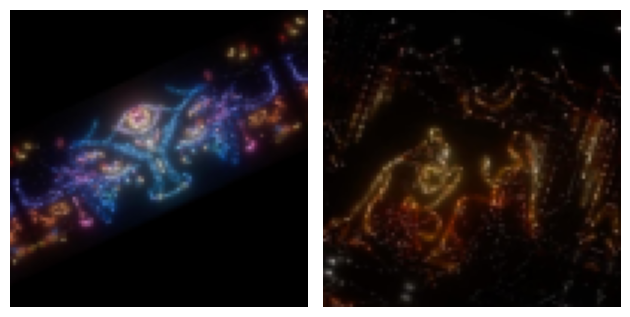

In [4]:
images, targets = next(iter(train_dl))
images, targets = images.to("cpu"), targets.float().to("cpu")

utils.plot_batch(targets, figsize=(5,5))

<Figure size 500x500 with 0 Axes>

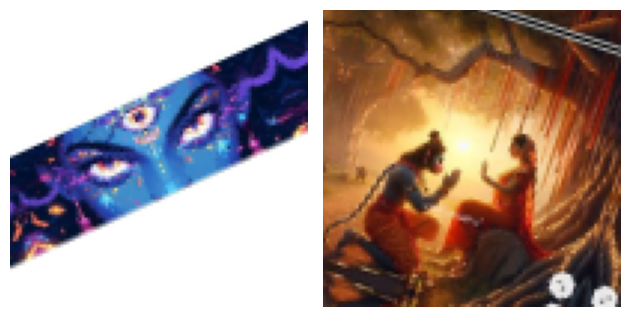

In [5]:
utils.plot_batch(images, figsize=(5,5))

In [8]:
1%5

1

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 640x480 with 0 Axes>

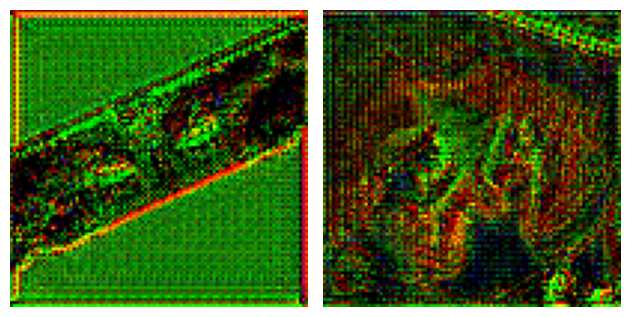

In [6]:
predictions = model(images)
utils.plot_batch(predictions,save_pth="wow.jpg", show=False)

In [13]:
with torch.amp.autocast('cuda'):
    predictions = model(images)
    loss = loss_fn(predictions, targets)
loss

tensor(0.4010, grad_fn=<DivBackward1>)

In [14]:
scaler = torch.amp.GradScaler('cuda')

optimizer.zero_grad()
scaler.scale(loss).backward()
scaler.step(optimizer)
scaler.update()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [15]:
with torch.amp.autocast('cuda'):
    predictions = model(images)
    loss = loss_fn(predictions, targets)
loss

tensor(0.3808, grad_fn=<DivBackward1>)

In [18]:
predictions = model(images)
utils.plot_batch(predictions,save_pth="wow.jpg", show=False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


AttributeError: Figure.set() got an unexpected keyword argument 'show'